In [1]:
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd
class DQN(torch.nn.Module):
    """Neural network that approximates Q-values for reinforcement learning."""
    
    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        """Initialize three-layer network: input -> hidden -> output."""
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward pass: state -> Q-values for each action."""
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

In [2]:
from collections import deque
import numpy as np
import random


class ReplayBuffer:
    def __init__(self, max_size: int = 10_000):
        """Initialize replay memory buffer.
        
        Args:
            max_size: Maximum buffer capacity (default 10000)
        """
        self.memory = deque(maxlen=max_size)
        self.max_size = max_size

    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in memory.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Episode termination flag
        """
        transition = (state, action, reward, next_state, done)
        self.memory.append(transition)

    def get_batch(self, batch_size: int):
        """Get random batch of transitions from memory.
        
        Args:
            batch_size: Size of batch to retrieve
            
        Returns:
            Tuple of (states, actions, rewards, next_states, dones)
        """
        if batch_size > len(self.memory):
            raise ValueError(f"Not enough samples in memory: {len(self.memory)}")
            
        # Get random sample
        batch = random.sample(self.memory, batch_size)
        
        # Unpack into separate lists
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to numpy arrays
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def __len__(self):
        """Return current memory size."""
        return len(self.memory)

    @property
    def is_ready(self):
        """Check if memory is ready for sampling."""
        return len(self.memory) > 0

In [3]:
import torch
import numpy as np
import random
from typing import Tuple

class DQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=50000, batch_size=64):
        """Initialize DQN Agent."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        
        # Initialize networks
        self.q_network = self._init_network(state_size, action_size, hidden_size)
        self.target_network = self._init_network(state_size, action_size, hidden_size)
        self._sync_target_network()
        
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def _init_network(self, state_size: int, action_size: int, hidden_size: int) -> torch.nn.Module:
        """Initialize and return network on correct device."""
        return DQN(state_size, action_size, hidden_size).to(self.device)

    def _sync_target_network(self):
        """Copy Q-network weights to target network."""
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

    def act(self, state: np.ndarray, epsilon: float = 0.0) -> int:
        """Choose action using epsilon-greedy policy."""
        if random.random() > epsilon:
            return self._get_best_action(state)
        return random.randrange(self.action_size)

    def _get_best_action(self, state: np.ndarray) -> int:
        """Get action with highest Q-value."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state)
        self.q_network.train()
        
        return np.argmax(q_values.cpu().numpy())

    def step(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        """Store experience and potentially update model."""
        self.memory.store_transition(state, action, reward, next_state, done)
        
        if len(self.memory) > self.batch_size:
            self._learn()

    def _learn(self):
        """Update Q-network using experience replay."""
        # Get batch
        batch = self._get_batch()
        states, actions, rewards, next_states, dones = batch
        
        # Get current Q values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # Get target Q values
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        # Update network
        loss = torch.nn.functional.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def _get_batch(self) -> Tuple:
        """Get and process batch from replay buffer."""
        states, actions, rewards, next_states, dones = self.memory.get_batch(self.batch_size)
        
        return (
            torch.from_numpy(states).float().to(self.device),
            torch.tensor(actions).long().to(self.device),
            torch.tensor(rewards).float().to(self.device),
            torch.from_numpy(next_states).float().to(self.device),
            torch.tensor(dones).float().to(self.device)
        )

    def update_target_network(self):
        """Update target network weights."""
        self._sync_target_network()

In [4]:
import gymnasium as gym
import numpy as np
from collections import deque
import imageio
import numpy as np

class DQNTrainer:
    def __init__(self, env, agent, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        self.env = env
        self.agent = agent
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.best_score = float('-inf')
        
    def train(self, n_episodes=500, target_update=10, early_stop_threshold=230):
        scores = []
        window_size = 100
        
        for episode in range(1, n_episodes + 1):
            score = self._run_episode()
            scores.append(score)
            
            self.eps = max(self.eps_end, self.eps_decay * self.eps)
            if episode % target_update == 0:
                self.agent.update_target_network()
                
            if len(scores) >= window_size:
                current_avg = np.mean(scores[-window_size:])
                self.best_score = max(self.best_score, current_avg)
                
                if current_avg >= early_stop_threshold:
                    print(f"\nReached threshold {early_stop_threshold} - stopping early")
                    return scores, self.best_score
            else:
                current_avg = np.mean(scores)
            
            self._print_progress(episode, current_avg)
                
        return scores, self.best_score
    
    def _run_episode(self):
        state, _ = self.env.reset()
        total_reward = 0
        
        while True:
            action = self.agent.act(state, self.eps)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            self.agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break
                
        return total_reward
        
    def _print_progress(self, episode, avg_score):
        print(f"\rEpisode {episode} | Avg Score: {avg_score:.2f} | Best: {self.best_score:.2f} | Epsilon: {self.eps:.3f}", end="")
        if episode % 100 == 0:
            print()


def visualize_agent(agent, env, n_episodes=10):
   env = gym.make('LunarLander-v3', render_mode='human')
   
   for episode in range(n_episodes):
       state, _ = env.reset()
       total_reward = 0
       
       while True:
           action = agent.act(state, 0)  # eps=0 dla deterministycznego zachowania
           next_state, reward, terminated, truncated, _ = env.step(action)
           total_reward += reward
           
           if terminated or truncated:
               print(f"Episode {episode+1} score: {total_reward:.2f}")
               break
           state = next_state

def evaluate(agent, env, num_episodes=100, max_steps=1000):
   all_rewards = []
   all_steps = []
   
   for i_episode in range(num_episodes):
       state, _ = env.reset()
       episode_reward = 0
       
       for step in range(max_steps):
           action = agent.act(state, 0)
           next_state, reward, terminated, truncated, _ = env.step(action)
           episode_reward += reward
           
           if terminated or truncated:
               break
           state = next_state
               
       all_rewards.append(episode_reward)
       all_steps.append(step + 1)
   
   avg_reward = np.mean(all_rewards)
   avg_steps = np.mean(all_steps)
   print(f"\nEvaluation over {num_episodes} episodes:")
   print(f"Average Reward: {avg_reward:.2f}")
   print(f"Average Episode Length: {avg_steps:.2f}")
   return avg_reward, avg_steps

def record_test(agent, filename='test.mp4', num_episodes=10):
   import imageio
   env = gym.make('LunarLander-v3', render_mode='rgb_array')
   frames = []
   
   for episode in range(num_episodes):
       state, _ = env.reset()
       done = False
       total_reward = 0
       last_state = None
       
       while not done:
           frame = env.render()
           frames.append(frame)
           last_state = state.copy()
           
           action = agent.act(state, 0)  
           next_state, reward, terminated, truncated, _ = env.step(action)
           done = terminated or truncated
           state = next_state
           total_reward += reward
   
   env.close()
   imageio.mimsave(f'videos/{filename}', frames, fps=30)

Episode 100 | Avg Score: -178.70 | Best: -178.70 | Epsilon: 0.905
Episode 200 | Avg Score: -115.15 | Best: -115.15 | Epsilon: 0.819
Episode 300 | Avg Score: -85.37 | Best: -83.98 | Epsilon: 0.74179
Episode 400 | Avg Score: -68.62 | Best: -68.62 | Epsilon: 0.670
Episode 500 | Avg Score: -74.62 | Best: -67.72 | Epsilon: 0.606
Episode 600 | Avg Score: -55.43 | Best: -55.04 | Epsilon: 0.549
Episode 700 | Avg Score: -46.13 | Best: -46.13 | Epsilon: 0.496
Episode 800 | Avg Score: -35.65 | Best: -27.10 | Epsilon: 0.449
Episode 900 | Avg Score: 8.99 | Best: 9.13 | Epsilon: 0.4061088
Episode 1000 | Avg Score: 17.94 | Best: 19.72 | Epsilon: 0.368
Episode 1100 | Avg Score: 48.70 | Best: 48.70 | Epsilon: 0.333
Episode 1200 | Avg Score: 66.23 | Best: 72.09 | Epsilon: 0.301
Episode 1300 | Avg Score: 69.87 | Best: 77.16 | Epsilon: 0.272
Episode 1400 | Avg Score: 68.92 | Best: 77.16 | Epsilon: 0.246
Episode 1500 | Avg Score: 64.28 | Best: 79.98 | Epsilon: 0.223
Episode 1600 | Avg Score: 116.75 | Best:

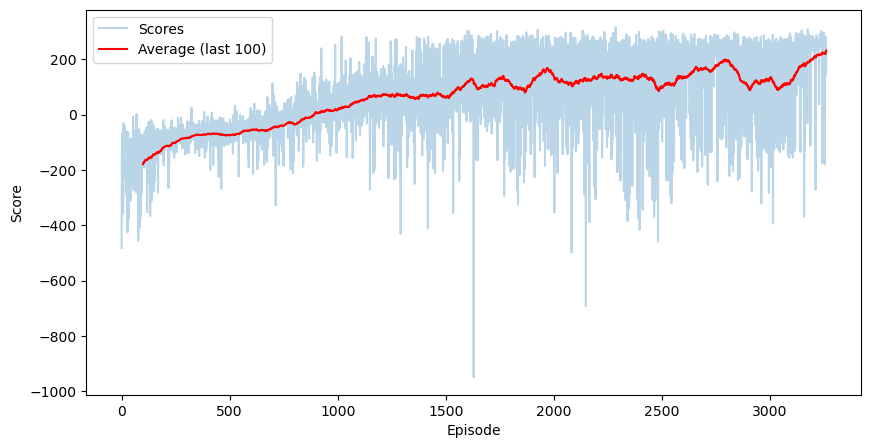

C:\Users\Oskar\AppData\Local\Temp\ipykernel_11336\2317695864.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_agent.q_network.load_state_dict(torch.load('lunar_la


Evaluation over 100 episodes:
Average Reward: 224.91
Average Episode Length: 327.10


In [5]:
if __name__ == "__main__":
   # Training
   env = gym.make('LunarLander-v3')
   agent = DQNAgent(
       state_size=env.observation_space.shape[0],
       action_size=env.action_space.n,
       hidden_size=64,
       learning_rate=1e-3
   )
   
   trainer = DQNTrainer(
       env=env,
       agent=agent,
       eps_start=1.0,
       eps_end=0.01,
       eps_decay=0.999
   )
   
   scores, best_score = trainer.train(
       n_episodes=4000,
       target_update=10,
       early_stop_threshold=230
   )
   
   # Plot and save training progress
   plt.figure(figsize=(10,5))
   plt.plot(scores, alpha=0.3, label='Scores')
   window_size = 100
   avg_scores = [np.mean(scores[i:i+window_size]) for i in range(len(scores)-window_size+1)]
   plt.plot(range(window_size-1, len(scores)), avg_scores, 'r', label=f'Average (last {window_size})')
   plt.xlabel('Episode')
   plt.ylabel('Score')
   plt.legend()
   plt.show()

   # Save scores to CSV
   pd.DataFrame({
       'episode': range(1, len(scores)+1),
       'score': scores,
       'avg_score': [np.nan]*(window_size-1) + avg_scores
   }).to_csv('training_scores.csv', index=False)

   # Save model
   torch.save(agent.q_network.state_dict(), 'lunar_lander_model')

   # Load and evaluate
   loaded_agent = DQNAgent(
       state_size=env.observation_space.shape[0],
       action_size=env.action_space.n,
       hidden_size=64,
       learning_rate=1e-3
   )
   loaded_agent.q_network.load_state_dict(torch.load('lunar_lander_model'))
   evaluate(loaded_agent, env, num_episodes=100)